In [22]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

# using high level interface
pars = {}
pars['neutrino_type']='nue' # nuebar, numu, numubar, nutau, nutaubar
pars['interaction_type']='NC' # CC, NC
pars['gamma']=1.5
pars['lEmin']=3.0  # Emin >= 3.0
pars['lEmax']=7.0  # Emax <= 7.0

nsamples = int(1.e6)
outfile = '/home/hans/icecube/projects/cascade_model/github/output/'+pars['neutrino_type']+'_'+pars['interaction_type']+'_simulation_gamma_'+str(pars['gamma'])+'_lEmin_'+str(pars['lEmin'])+'_lEmax_'+str(pars['lEmax'])+'_fixed.h5'
print outfile

/home/hans/icecube/projects/cascade_model/github/output/nue_NC_simulation_gamma_1.5_lEmin_3.0_lEmax_7.0_fixed.h5


In [23]:
import pandas
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from scipy.integrate import quad

df = pandas.read_hdf(outfile)
print df.columns.values

# construct conditional distribution f(E_dep | Enu , i, j) 
# where i in [NC, CC] (interaction type) and j in [nue, nuebar, numu, numubar, nutau, nutaubar] (neutrino type)

# we use law of total probability
# f(E_dep | Enu , i, j) = f(E_dep, Enu | i, j) / f(Enu | i, j)
# note LHS does not depend on flux model and thus neither thus RHS
# but both terms on RHS separately depend on flux model
# we construct both of them here

['generation_weight' 'prim_coszenith' 'rec_coszenith' 'dep_energy'
 'rec_energy' 'prim_energy' 'prim_azimuth' 'rec_azimuth' 'bjorken_y']


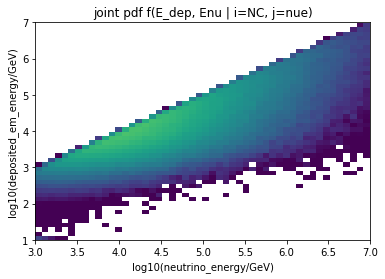


... constructing 2 dim. KDE (fixed bandwith)


... constructing 2 dim. KDE (adaptive bandwith)



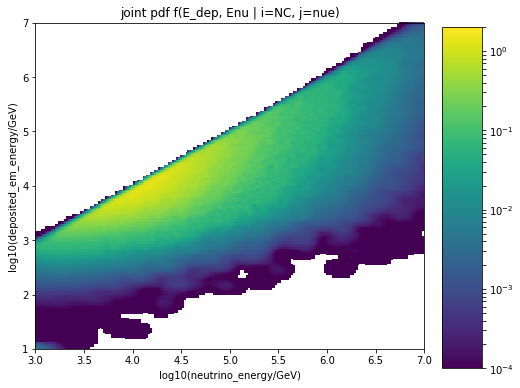

              logEnu INFO: Creating 1D phase space in range (3.000000, 7.000000)
             logEdep INFO: Creating 1D phase space in range (-1.000000, 8.000000)
        PhspCombined INFO: Creating combined phase space of 2 components
        PhspCombined INFO: Adding component phase space "logEnu", dim=1
        PhspCombined INFO: Adding component phase space "logEdep", dim=1
        PhspCombined INFO: Resulting dimensionality is 2
           KernelPDF INFO: Creating binned kernel density over 2D phase space
           KernelPDF INFO: Map size=40000
           KernelPDF INFO: Using variable "weight" as weight
           KernelPDF INFO: Will read 1000000 events (skipping first 0)
           KernelPDF INFO: Will read branch "logEnu" from tree "tree"
           KernelPDF INFO: Will read branch "logEdep" from tree "tree"
           KernelPDF INFO: Will read branch "weight" from tree "tree"
           KernelPDF INFO: 1000000 events read in from "tree", 0 out
           KernelPDF INFO: Wil

In [28]:
# joint distribution P(E_dep, Enu | i, j)
# we use E^-2 as flux model (arbitrary choice)
gamma = 2.5
norm = 1.*10**(-18)
ltime = 365. * 24. * 3600. * 2. # assume 2 years of livetime for rate (arbitrary choice)
importance_weights=df['generation_weight']*np.power(df['prim_energy']/1.e5,-gamma)* norm * ltime
plt.hist2d(np.log10(df['prim_energy']), np.log10(df['dep_energy']), weights=importance_weights, bins=50, norm=LogNorm(10**-5,10**0))
plt.ylim([1, 7.0])
plt.xlim([3.0, 7.0])
plt.title('joint pdf f(E_dep, Enu | i=NC, j=nue)')
plt.xlabel('log10(neutrino_energy/GeV)')
plt.ylabel('log10(deposited_em_energy/GeV)')
plt.show()

# shall we generate a new kde, or can we read the pre-computed kde from disk
generate_kde = True

if generate_kde:
    from kde import *
    args_enu = {'name':'logEnu', 'values': np.log10(df['prim_energy'].values), 'bandwidth': 0.05, 'nbins':200, 'range': [pars['lEmin'], pars['lEmax']]}
    args_edep = {'name':'logEdep', 'values': np.log10(df['dep_energy'].values), 'bandwidth': 0.05, 'nbins':200, 'range': [-1., pars['lEmax']+1]}
    m_input = meerkat_input([args_enu, args_edep], importance_weights, mc_conv=nsamples, adaptive=False)
    m_kde_seed = meerkat_kde(m_input)
    
    
    m_input = meerkat_input([args_enu, args_edep], importance_weights, mc_conv=nsamples, adaptive=True, pdf_seed=m_kde_seed.kde)
    m_kde_joint = meerkat_kde(m_input)

# now visualize result
# we use rootpy.plotting for convenience
import rootpy.plotting.root2matplotlib as rplt
from rootpy.plotting import Hist, Hist2D

nbins_x = 200
nbins_y = 200
et_bins = np.linspace(3.0, 7.0, nbins_x)
edep_bins = np.linspace(1.0, 7.0, nbins_x)
hist = Hist2D(et_bins, edep_bins)

outfile_2D='./output/kde2D_'+pars['neutrino_type']+'_'+pars['interaction_type']+'_simulation_gamma_'+str(pars['gamma'])+'_lEmin_'+str(pars['lEmin'])+'_lEmax_'+str(pars['lEmax'])+'_fixed.txt'
# need to evaluate kde if result does not exist already on disk
if generate_kde:
    xvals = []
    yvals = []
    zvals = []
    for tbin in hist:
        tx = tbin.x.center
        ty = tbin.y.center
        tz = m_kde_joint.eval_point([tbin.x.center, tbin.y.center])
        tbin.value = tz
        xvals.append(tx)
        yvals.append(ty)
        zvals.append(tz)
    
    result = np.column_stack((np.asarray(xvals), np.asarray(yvals), np.asarray(zvals)))
    np.savetxt(outfile_2D, result)

# read from disk if possible
else:
    dat = np.loadtxt(outfile_2D)
    j=0
    for tbin in hist:
        tbin.value = dat[:,2][j]
        j+=1

# and here is the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(right=0.8)
cmap = plt.get_cmap('viridis')
lin = rplt.hist2d(hist, axes=ax, cmap = cmap, norm=mpl.colors.LogNorm(vmin=1.e-4, vmax=2.))                                                                                           
plt.title('joint pdf f(E_dep, Enu | i=NC, j=nue)')
plt.xlabel('log10(neutrino_energy/GeV)')
plt.ylabel('log10(deposited_em_energy/GeV)')
cbar_ax1 = fig.add_axes([0.83, 0.08, 0.07, 0.79])
cbar = fig.colorbar(lin[3], cbar_ax1)
plt.show()



... constructing 1 dim. KDE (fixed bandwith)



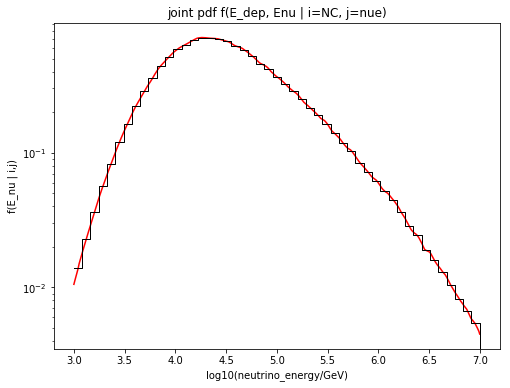

              logEnu INFO: Creating 1D phase space in range (3.000000, 7.000000)
           KernelPDF INFO: Creating binned kernel density over 1D phase space
           KernelPDF INFO: Map size=400
           KernelPDF INFO: Using variable "weight" as weight
           KernelPDF INFO: Will read 1000000 events (skipping first 0)
           KernelPDF INFO: Will read branch "logEnu" from tree "tree"
           KernelPDF INFO: Will read branch "weight" from tree "tree"
           KernelPDF INFO: 1000000 events read in from "tree", 0 out
           KernelPDF INFO: Will use uniform density for approximation
           KernelPDF INFO: Convolution of approx. density using rectangular grid
           KernelPDF INFO: Normalising density
           KernelPDF INFO: Average PDF value before normalisation is 0.007357


In [30]:
# to get to the conditional distribution we need the second term on the RHS
# f(Enu | i, j) - this a simple 1D KDE

# shall we generate a new kde, or can we read the pre-computed kde from disk
generate_kde = True

if generate_kde:
    from kde import *
    args_enu = {'name':'logEnu', 'values': np.log10(df['prim_energy'].values), 'bandwidth': 0.05, 'nbins':400, 'range': [pars['lEmin'], pars['lEmax']]}
    m_input = meerkat_input([args_enu], importance_weights, mc_conv=nsamples, adaptive=False)
    m_kde_marginal = meerkat_kde(m_input)


# now visualize result
# we use rootpy.plotting for convenience
import rootpy.plotting.root2matplotlib as rplt
from rootpy.plotting import Hist

nbins_x = 50
et_bins = np.linspace(3.0, 7.0, nbins_x)

hist = Hist(et_bins)
hist.fill_array(np.log10(df['prim_energy'].values), importance_weights)
hist.Scale(1./hist.Integral("width"))
outfile_1D='./output/kde1D_'+pars['neutrino_type']+'_'+pars['interaction_type']+'_simulation_gamma_'+str(pars['gamma'])+'_lEmin_'+str(pars['lEmin'])+'_lEmax_'+str(pars['lEmax'])+'_fixed.txt'
# need to evaluate kde if result does not exist already on disk
if generate_kde:
    nsteps = 1000
    xvals = np.linspace(3.0, 7.0, nsteps)
    zvals = [m_kde_marginal.eval_point([tx]) for tx in xvals]    
    result = np.column_stack((np.asarray(xvals), np.asarray(zvals)))
    np.savetxt(outfile_1D, result)
    dat = result
    
# read from disk if possible
else:
    dat = np.loadtxt(outfile_1D)

# and here is the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.plot(dat[:,0], dat[:,1], "r-")
rplt.step(hist)
plt.title('joint pdf f(E_dep, Enu | i=NC, j=nue)')
plt.xlabel('log10(neutrino_energy/GeV)')
plt.ylabel('f(E_nu | i,j)')
plt.yscale('log')
plt.show()


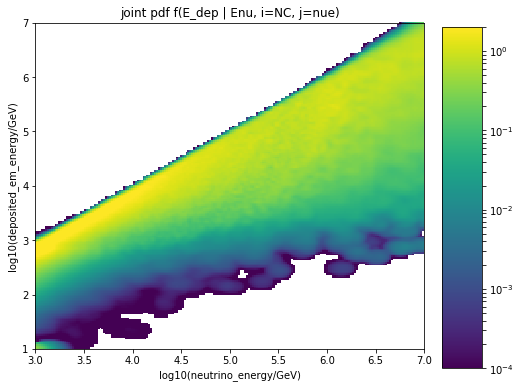

In [92]:
# now construct the conditional (LHS) by dividing the two KDEs
# f( Edep | Enu, i, j) 
# ATTENTION: this only works, if the KDE functions are still in memory
# make sure to execute with "generate_kde=True" in the previous paragraphs if the conditional is not already on disk

nbins_x = 200
nbins_y = 200
et_bins = np.linspace(3.0, 7.0, nbins_x)
edep_bins = np.linspace(1.0, 7.0, nbins_x)
hist = Hist2D(et_bins, edep_bins)

outfile_2D='./output/conditional_2D_'+pars['neutrino_type']+'_'+pars['interaction_type']+'_simulation_gamma_'+str(pars['gamma'])+'_lEmin_'+str(pars['lEmin'])+'_lEmax_'+str(pars['lEmax'])+'_fixed.txt'

generate_conditional = False
if generate_conditional:
    xvals = []
    yvals = []
    zvals = []
    for tbin in hist:
        tx = tbin.x.center
        ty = tbin.y.center
        pdf_joint = m_kde_joint.eval_point([tbin.x.center, tbin.y.center])
        pdf_marginal = m_kde_marginal.eval_point([tbin.x.center])
        if pdf_marginal:
            tz = pdf_joint / pdf_marginal
        else:
            tz = 0.0
        tbin.value = tz
        xvals.append(tx)
        yvals.append(ty)
        zvals.append(tz)
    
    result = np.column_stack((np.asarray(xvals), np.asarray(yvals), np.asarray(zvals)))
    np.savetxt(outfile_2D, result)
    
# read from disk if possible
else:
    dat = np.loadtxt(outfile_2D)
    j=0
    for tbin in hist:
        tbin.value = dat[:,2][j]
        j+=1

# and here is the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(right=0.8)
cmap = plt.get_cmap('viridis')
lin = rplt.hist2d(hist, axes=ax, cmap = cmap, norm=mpl.colors.LogNorm(vmin=1.e-4, vmax=2.))                                                                                           
plt.title('joint pdf f(E_dep | Enu, i=NC, j=nue)')
plt.xlabel('log10(neutrino_energy/GeV)')
plt.ylabel('log10(deposited_em_energy/GeV)')
cbar_ax1 = fig.add_axes([0.83, 0.08, 0.07, 0.79])
cbar = fig.colorbar(lin[3], cbar_ax1)
plt.show()


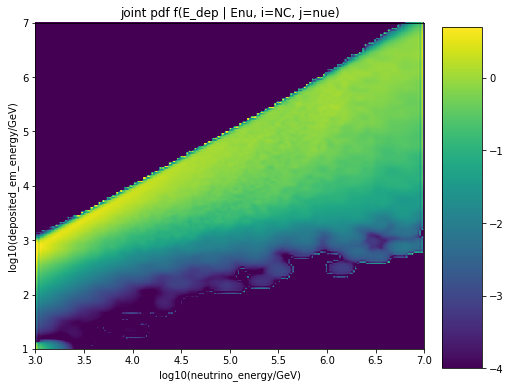

In [148]:
from scipy.interpolate import RectBivariateSpline 

# in order to integrate into stan we will perform a spline fit to this pdf
outfile_2D='./output/conditional_2D_'+pars['neutrino_type']+'_'+pars['interaction_type']+'_simulation_gamma_'+str(pars['gamma'])+'_lEmin_'+str(pars['lEmin'])+'_lEmax_'+str(pars['lEmax'])+'_fixed.txt'
dat = np.loadtxt(outfile_2D)

log_enu = dat[:,0]
log_edep = dat[:,1]

log_enu_axis = sorted(np.unique(log_enu))
log_edep_axis = sorted(np.unique(log_edep))

orig_cond_pdf = dat[:,2]
cond_pdf = []
for val in orig_cond_pdf:
    if val:
        cond_pdf.append(np.log10(val))
    else:
        cond_pdf.append(-20.)
        
cond_pdf = np.asarray(cond_pdf)
cond_pdf = cond_pdf.reshape(len(log_enu_axis), len(log_edep_axis))
cond_pdf = cond_pdf.T


pdf_spline = RectBivariateSpline(log_enu_axis, log_edep_axis, cond_pdf, s=0)
nbins_x = 500
nbins_y = 500
et_bins = np.linspace(3.0, 7.0, nbins_x)
edep_bins = np.linspace(1.0, 7.0, nbins_x)
hist = Hist2D(et_bins, edep_bins)
for tbin in hist:
    tval = pdf_spline(tbin.x.center, tbin.y.center)
    tbin.value = tval

    
# and here is the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(right=0.8)
cmap = plt.get_cmap('viridis')
lin = rplt.hist2d(hist, axes=ax, cmap = cmap , norm=mpl.colors.Normalize(vmin=-4.,vmax=0.7))                                                                                           
plt.title('joint pdf f(E_dep | Enu, i=NC, j=nue)')
plt.xlabel('log10(neutrino_energy/GeV)')
plt.ylabel('log10(deposited_em_energy/GeV)')
cbar_ax1 = fig.add_axes([0.83, 0.08, 0.07, 0.79])
cbar = fig.colorbar(lin[3], cbar_ax1)
plt.show()

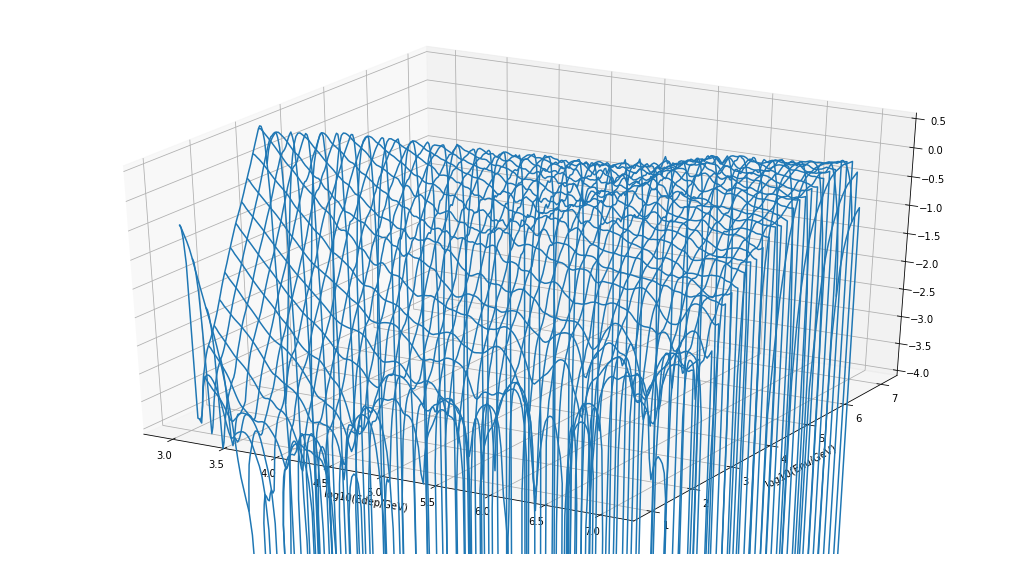

In [145]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
et_bins += 0.5*(et_bins[5]-et_bins[4])
edep_bins += 0.5*(edep_bins[5]-edep_bins[4])
xx, yy = np.meshgrid(et_bins, edep_bins)
xx = xx.T
yy = yy.T

zvals = pdf_spline(et_bins, edep_bins)

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, zvals, rstride=5, cstride=5)
ax.set_xlabel('log10(Edep/GeV)')
ax.set_ylabel('log10(Enu/GeV)')
ax.set_zlim([-4.0, 0.5])
plt.show()

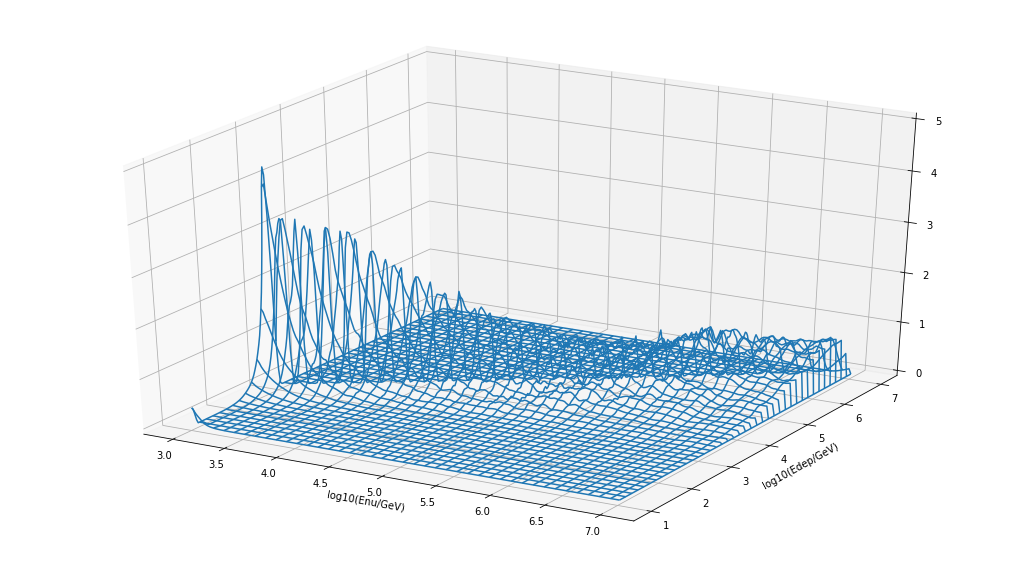

In [146]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
xx, yy = np.meshgrid(et_bins, edep_bins)
xx = xx.T
yy = yy.T

zvals = 10**zvals

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, zvals, rstride=5, cstride=5)
ax.set_xlabel('log10(Enu/GeV)')
ax.set_ylabel('log10(Edep/GeV)')
ax.set_zlim([0.0,5.0])
plt.show()